In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


1. Setup and Data Preparation

In [2]:


# Step 1: Load the Fashion-MNIST dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
)

# Step 2: Preprocess the dataset
# Define transformations for training and testing
# Updated train and test transforms with grayscale conversion to 3 channels
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformations to datasets
train_data.transform = train_transforms
test_data.transform = test_transforms

# Create DataLoader for training and testing
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print the dataset and DataLoader details
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")


Number of training samples: 60000
Number of testing samples: 10000


2. Model Building

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Step 1: Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Step 3: Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Replace the fully connected (fc) layer to match the number of classes
n_classes = 10  # Fashion-MNIST has 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

# Step 4: Fine-tuning after a few epochs
def enable_fine_tuning():
    print("Unfreezing earlier layers for fine-tuning.")
    for param in model.parameters():
        param.requires_grad = True

# Use this function later in the training process to unfreeze the layers


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


3. Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 10
unfreeze_epoch = 5  # Fine-tuning starts after this epoch

# Step 2: Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Step 3: Prepare to store metrics for visualization later
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_accuracy = 0.0  # To track the best performing model

# Step 4: Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Enable fine-tuning at the specified epoch
    if epoch == unfreeze_epoch:
        print("Enabling fine-tuning...")
        enable_fine_tuning()  # Unfreeze earlier layers
        optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower the learning rate for fine-tuning

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store results for metrics calculation
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Step 5: Calculate and store training metrics
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_accuracy:.4f}")

    # Step 6: Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate and store validation metrics
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_accuracy = accuracy_score(val_labels, val_preds)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Step 7: Save the best model based on validation accuracy
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), "best_resnet_fashion_mnist.pth")
        print("Best model saved!")

Epoch [1/10] | Train Loss: 0.6822 | Train Accuracy: 0.7671
Validation Loss: 0.5672 | Validation Accuracy: 0.8014
Best model saved!
Epoch [2/10] | Train Loss: 0.5336 | Train Accuracy: 0.8087
Validation Loss: 0.5735 | Validation Accuracy: 0.7991
Epoch [3/10] | Train Loss: 0.5116 | Train Accuracy: 0.8161
Validation Loss: 0.5105 | Validation Accuracy: 0.8188
Best model saved!
Epoch [4/10] | Train Loss: 0.4996 | Train Accuracy: 0.8193
Validation Loss: 0.5083 | Validation Accuracy: 0.8168
Epoch [5/10] | Train Loss: 0.4943 | Train Accuracy: 0.8223
Validation Loss: 0.4948 | Validation Accuracy: 0.8240
Best model saved!
Enabling fine-tuning...
Unfreezing earlier layers for fine-tuning.
Epoch [6/10] | Train Loss: 0.3019 | Train Accuracy: 0.8938
Validation Loss: 0.2196 | Validation Accuracy: 0.9214
Best model saved!
Epoch [7/10] | Train Loss: 0.2013 | Train Accuracy: 0.9270
Validation Loss: 0.1803 | Validation Accuracy: 0.9336
Best model saved!
Epoch [8/10] | Train Loss: 0.1746 | Train Accuracy: 

4. Evaluation

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch

model.eval() 
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9352
Precision: 0.9369
Recall: 0.9352
F1 Score: 0.9348


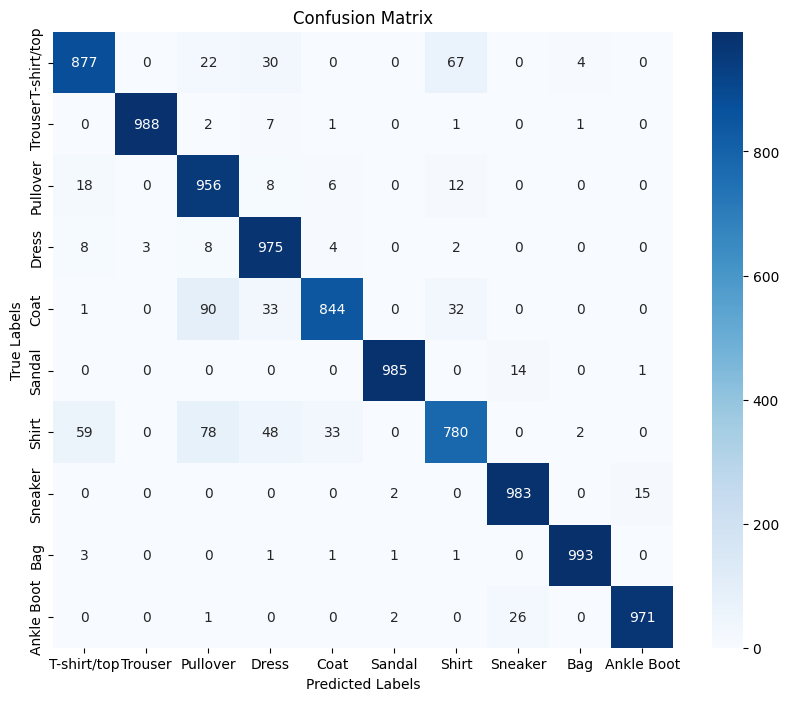

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels for Fashion-MNIST
class_labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


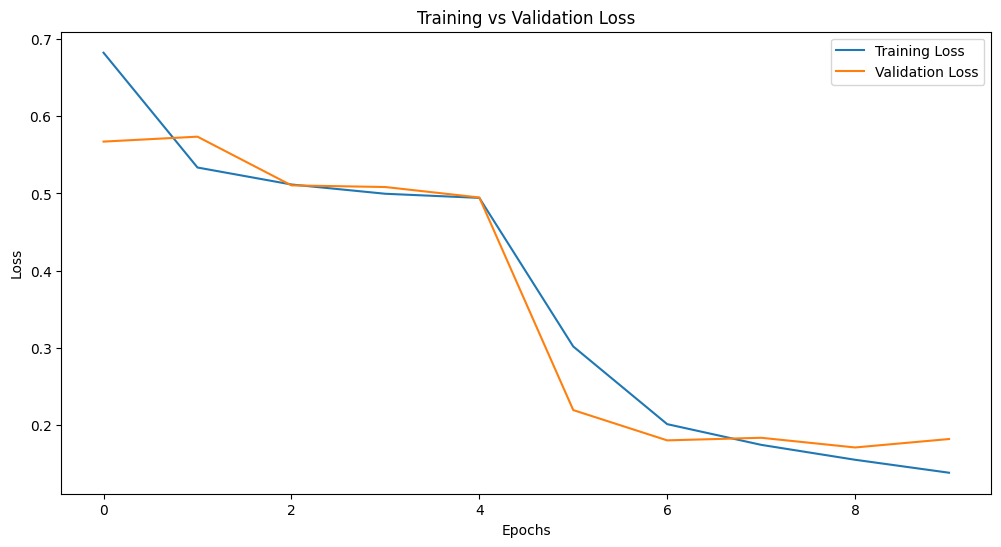

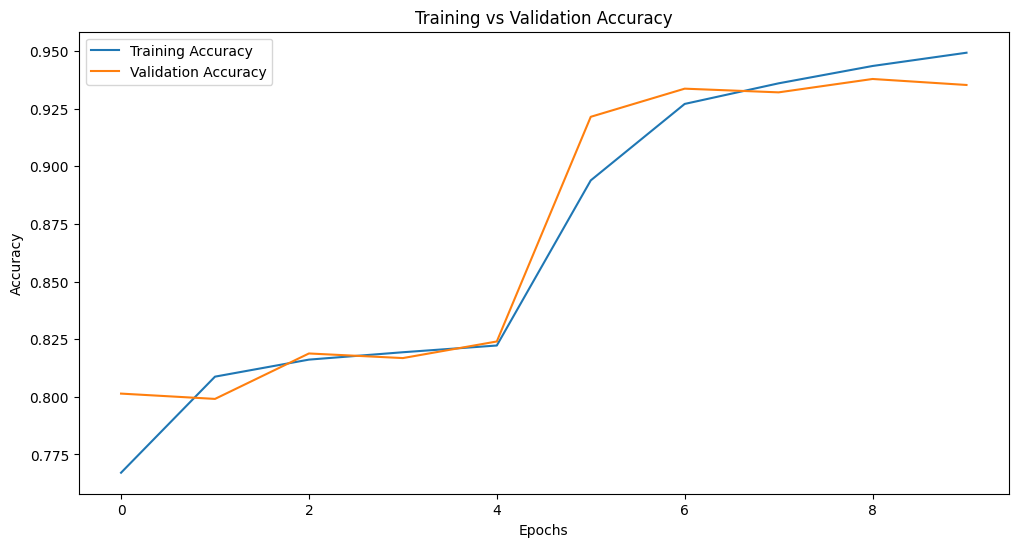

In [6]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()